# Assignment 2 - Home Credit Default Risk Dataset
  **Author :** Diya Bedi

  **Date :** 22nd October 2025
  
  **Purpose :** Train and tune tree-based and boosting models -> Analyze bias-variance trade-off -> Visualize feature importance

  **Task :** Predict whether an applicant will repay a loan, using a wide range of application, credit, and behavioral data.

In [42]:
!pip install xgboost

In [1]:
# Importing libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

#machine learning libraries
from sklearn.model_selection import RandomizedSearchCV #faster than gridsearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import (average_precision_score, accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report, 
                             precision_recall_curve, auc, roc_auc_score)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#for XGBoost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

#for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1. Data Preparation 

We will start by loading the dataset `application_train.csv` using `pandas`. 

After loading, we’ll check:
- Number of rows and columns (size of data)
- What columns exist
- The target variable distribution (`TARGET`)
- Some basic EDA to understand more about the skewness, outliers and distribution of the dataset

### 1.1 Loading the data

In [2]:
df = pd.read_csv("application_train.csv")
print("Rows, Columns: ", df.shape)
df.head()

Rows, Columns:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### 1.2 Quick Checks for missing data and imbalanced target set

Each row is a loan application.  
- The `TARGET` column is what we want to predict:  
  - `1` → client defaulted on the loan  
  - `0` → client repaid the loan

Here I am checking: 
1. Target Balance
2. Data Types - numerical and categorical
3. Missing Values
   
If the target is strongly imbalanced, accuracy will be misleading, so we will use other metrics like precision and AUC to check our model later 

In [3]:
#Target Balance 
print("Target Distribution to understand the dataset")
print(df["TARGET"].value_counts(normalize=True))

#Data Types
print("\nColumn types summary:")
print(df.dtypes.value_counts())                               

Target Distribution to understand the dataset
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Column types summary:
float64    65
int64      41
object     16
Name: count, dtype: int64


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [5]:
#Checking missing values
missing_value = df.isnull().sum().sort_values(ascending = False)
missing_percent = 100 * df.isnull().sum() / len(df)
missing_val_table = pd.concat([missing_value, missing_percent], axis=1)
missing_val_table = missing_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
missing_val_table

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
...,...,...
NAME_HOUSING_TYPE,0,0.000000
NAME_FAMILY_STATUS,0,0.000000
NAME_EDUCATION_TYPE,0,0.000000
NAME_INCOME_TYPE,0,0.000000


In [6]:
#checking duplicated columns
display(df.duplicated().sum())

np.int64(0)

In [7]:
num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()
df[num_cols].describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


Understanding the categorical values, how many unique values each variable has. 

In [8]:
df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

**Observation:** 
- The dataset is large with 307511 rows and 122 columns.
- The target variable is imbalanced, only 8% of people defaulted. The class imbalance represents that we'll need to consider this during model evaluation by focusing on metrics like Precision-Recall rather than just accuracy.
- Several Columns have missing values, some even over 70%, which we need to handle carefully before modelling.
- The categorical variables doesn't have a lot of unique values, so we will need to encode them as well

### 1.3 Basic EDA

With this, I am visualizing the target imbalance and also some important numeric features like income and credit amount, this will help me better to get a sense of skewness and scale.

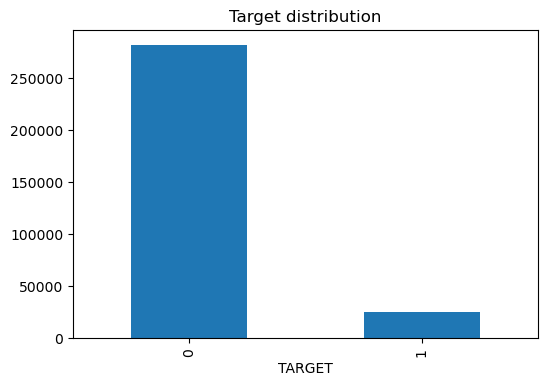

In [9]:
plt.figure(figsize=(6,4))
df["TARGET"].value_counts().plot(kind="bar")
plt.title("Target distribution")
plt.show()

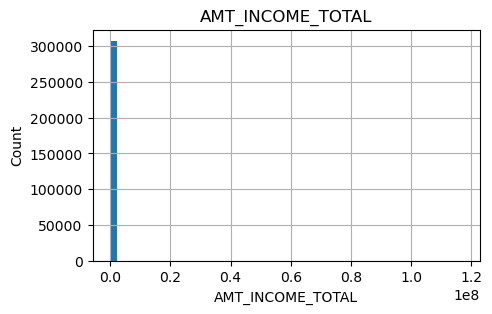

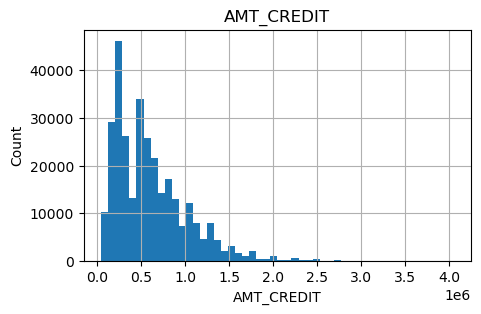

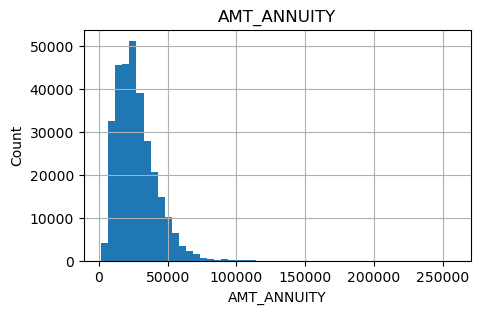

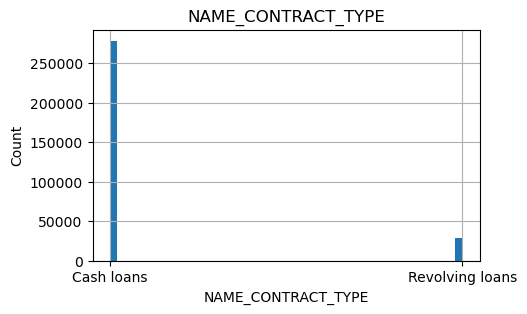

In [10]:
for col in ["AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY", "NAME_CONTRACT_TYPE"]:
    if col in df.columns:
        plt.figure(figsize=(5,3))
        df[col].hist(bins=50)
        plt.title(col)
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.show()

**Observation**: 
- Credit, Income and Annuity are highly **rightly skewed**, most values are small, few are very large.
- Many clients have low income closer to 0, represented by the tall bar. But they also have very high loans that represents a risk factor.
- This suggests, we can apply **log tranformation** to reduce skewness and standardize the data for better use.
- Most common type of loan is Cash Loans with a few revolving loans. 

### 1.4 Data Cleaning

1. I am going to drop the columns that are mostly missing (>90%)
2. Split features (X) and Target (Y)
3. Imputate missing numeric values with **median**.
4. Imputate categorical values with **mode** or flag with **missing**.
5. Convert text columns to numeric using **Label Encoding**

In [62]:
#Drop columns with 50% missing data
missing_ratio = df.isnull().mean()
cols_drop = missing_ratio[missing_ratio > 0.5].index
df = df.drop(columns = cols_drop)
df.shape

(307511, 81)

No columns were dropped as no column has more than 90% missing data, our missing data is upto 70% so we will choose other ways to fill it. 

### Splitting the dataset: 
I am splitting the dataset as 70% train, 15% validation and 15% test (Stratified by TARGET).

All preprocessing (imputation and encoding, points 3 to 5, will be fit **only** on the training partition and applied to validation and test.

In [63]:
X = df.drop(columns=["TARGET", "SK_ID_CURR"]) #SK_ID_CURR is dropped to prevent overfitting
y = df["TARGET"].astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size = 0.30, stratify = y, random_state=RANDOM_STATE)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=RANDOM_STATE)

print("Train:", X_train.shape, "\nValidation:", X_val.shape, "\nTest:", X_test.shape)
print("Train positive rate:", y_train.mean(), "\nValidation positive rate:", y_val.mean(), "\nTest positive rate:", y_test.mean())

Train: (215257, 79) 
Validation: (46127, 79) 
Test: (46127, 79)
Train positive rate: 0.08072675917624049 
Validation positive rate: 0.08073362672621241 
Test positive rate: 0.08073362672621241


Splitting first prevents any data leakage to the test test. This is essential for honest evaluation.

### Preprocessing Pipeline

Here I am going to:
1. Identify numeric and categorical columns.
2. For numeric, use SimpleImputer with Median Strategy.
3. For categorical, fill missing values with "MISSING" and implement a label encoder.
     - Learns mappings (category → integer) from the **training set** only.
     - Applies the same mapping to validation/test.
     - Maps **unseen categories** to `-1`.
5. Use ColumnTransformer + Pipeline to produce a single fitted preprocessing object.

In [64]:
#Numerical and Categorical
num_cols = X_train.select_dtypes(include=["int64","float64"]).columns.to_list()
cat_cols = X_train.select_dtypes(include=["object"]).columns.to_list()
print("numeric: ", len(num_cols))
print("categorical: ", len(cat_cols))

numeric:  66
categorical:  13


In [65]:
le = LabelEncoder()
le_count = 0

for col in cat_cols:
    if len(list(X_train[col].unique())) <= 2:
        # Train on the training data
        le.fit(X_train[col])
        # Transform both training and testing data
        X_train[col] = le.transform(X_train[col])
        X_test[col] = le.transform(X_test[col])
            
        # Keep track of how many columns were label encoded
        le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


Label Encoding is chosen over One-Hot Encoding because:
1. Tree-based models can handle ordinal encoding naturally
2. Avoids dimensionality explosion with high-cardinality features
3. Boosting algorithms (XGBoost, LightGBM) work efficiently with label-encoded data

In [66]:
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy = "median"))
    ])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy = "constant", fill_value="MISSING")), 
    ("ode", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_cols),
    ("cat", categorical_pipeline, cat_cols)
], 
remainder = "drop")

#Preprocessing outside the pipeline to fit once
X_train_proc = preprocessor.fit_transform(X_train)
X_val_proc   = preprocessor.transform(X_val)
X_test_proc  = preprocessor.transform(X_test)

## 2) Baseline Model: Decision Tree

- I will start with a decision tree classifier (criterion = Gini)
- I am using `GridSearchCV` to tune hyperparameters like `max_depth`, `min_samples_split`, `ccp_alpha`
- Optimize for Average Precision to handle class imbalance

### 2.1 Decision Tree Model and Tuning
#### Decision Tree Basic
Decision Trees serve as an excellent baseline because:
- They're the building blocks of boosting algorithms
- Easy to visualise overfitting vs underfitting through depth tuning
- Provide interpretable feature importance
- Help establish performance expectations before ensemble methods

In [67]:
dt_pipeline = Pipeline([
    ("pre", preprocessor), 
    ("clf", DecisionTreeClassifier(criterion = "gini", random_state = RANDOM_STATE))
])

dt_pipeline.fit(X_train, y_train)

train_acc_basic = accuracy_score(y_train, dt_pipeline.predict(X_train))
val_acc_basic = accuracy_score(y_val, dt_pipeline.predict(X_val))

print(f"Basic DT - Train Accuracy: {train_acc_basic:.4f}")
print(f"Basic DT - Validation Accuracy: {val_acc_basic:.4f}")
print(f"Overfit gap: {train_acc_basic - val_acc_basic:.4f}")

Basic DT - Train Accuracy: 1.0000
Basic DT - Validation Accuracy: 0.8485
Overfit gap: 0.1515


**Observation**: The basic decision tree shows significant overfitting (perfect training accuracy but lower validation accuracy). This motivates the need for:
1. Pruning (via max_depth, min_samples_split, ccp_alpha)
2. Ensemble methods that combat overfitting through aggregation

#### Hyperparameter Tuning

In [68]:
dt = DecisionTreeClassifier(criterion = "gini", random_state = RANDOM_STATE)

param_grid = {
    "max_depth": [4, 6, 8, 10, 12, None],
    "min_samples_split": [50, 100, 300],
    "ccp_alpha": [0.0, 1e-4, 1e-3]
}

grid_dt = GridSearchCV(dt, param_grid, cv=5, scoring="average_precision", n_jobs=-1, verbose=1)
grid_dt.fit(X_train_proc, y_train)

best_dt = grid_dt.best_estimator_
print("Best parameters:", grid_dt.best_params_)
print("Validation AP:", average_precision_score(y_val, best_dt.predict_proba(X_val_proc)[:,1]))

Fitting 5 folds for each of 54 candidates, totalling 270 fits


KeyboardInterrupt: 

In [18]:
#Building evaluate model function for all models

def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    results = {}
    
    for split_name, X_split, y_split in [('Train', X_train, y_train), 
                                           ('Val', X_val, y_val), 
                                           ('Test', X_test, y_test)]:
        y_pred = model.predict(X_split)
        y_pred_proba = model.predict_proba(X_split)[:, 1]
        
        results[split_name] = {
            'Accuracy': accuracy_score(y_split, y_pred),
            'Precision': precision_score(y_split, y_pred, zero_division=0),
            'Recall': recall_score(y_split, y_pred),
            'F1': f1_score(y_split, y_pred),
            'ROC-AUC': roc_auc_score(y_split, y_pred_proba),
            'AP': average_precision_score(y_split, y_pred_proba)
        }
        
        # Calculate PR-AUC
        precision, recall, _ = precision_recall_curve(y_split, y_pred_proba)
        results[split_name]['PR-AUC'] = auc(recall, precision)
    
    # Print results
    print(f"\n{model_name} Results:")
    print("-" * 70)
    results_df = pd.DataFrame(results).T
    print(results_df.round(4))
    
    return results, results_df

In [19]:
#Evaluating for Decision Tree
dt_results, dt_results_df = evaluate_model(
    best_dt, X_train_proc, y_train, X_val_proc, y_val, X_test_proc, y_test, 
    "Tuned Decision Tree"
)


Tuned Decision Tree Results:
----------------------------------------------------------------------
       Accuracy  Precision  Recall      F1  ROC-AUC      AP  PR-AUC
Train    0.9199     0.6241  0.0194  0.0376   0.7344  0.2215  0.2277
Val      0.9189     0.4308  0.0150  0.0291   0.7180  0.1915  0.1948
Test     0.9184     0.3360  0.0113  0.0218   0.7211  0.1911  0.1945


Key things to observe:
- Accuracy is misleading due to class imbalance.
- PR-AUC is more informative than ROC-AUC for imbalanced datasets
- The gap between train and validation metrics indicates generalisation ability.
- Single trees typically have high variance (sensitive to training data).

### 2.2 Learning Curve: Bias vs Variance

We analyze **max_depth vs performance** to visualize bias-variance tradeoff. 

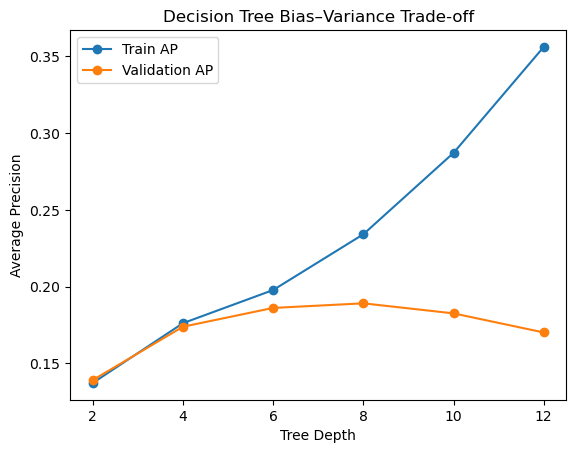

In [20]:
depths = [2, 4, 6, 8, 10, 12]
train_ap, val_ap = [], []

for d in depths:
    model= DecisionTreeClassifier(max_depth=d, random_state=RANDOM_STATE)
    model.fit(X_train_proc, y_train)
    train_ap.append(average_precision_score(y_train, model.predict_proba(X_train_proc)[:,1]))
    val_ap.append(average_precision_score(y_val, model.predict_proba(X_val_proc)[:,1]))

plt.plot(depths, train_ap, label="Train AP", marker='o')
plt.plot(depths, val_ap, label="Validation AP", marker='o')
plt.xlabel("Tree Depth")
plt.ylabel("Average Precision")
plt.title("Decision Tree Bias–Variance Trade-off")
plt.legend()
plt.show()

**Observation**: The learning curve reveals:
1. High Bias: If both curves plateau at low scores → underfitting (model too simple)
2. High Variance: If a large gap between curves → overfitting (model memorises training data)
3. Ideal: Curves converge at high scores → good generalisation
4. Train AP (Average Precision) shows that as the tree depth increases, training average precision consistently rises. This indicates model is fitting the training data closely.
5. Validation AP line shows that the validation precision increases initially but with increasing depth, it slightly decreases. This suggests that the model is beginning to overfit so we need to prune before this. Like here tree depth = 8.
For decision trees, we typically see high variance that boosting will help address

## 3. Boosting Methods

We will implement boosting algorithms and then compare it with the baseline-tree.

### 3.1 Gradient Boosting
Gradient Boosting builds models sequentially, where each new tree corrects errors of previous trees.
We have:
- Learning Rate: Controls contribution of each tree (smaller = more robust but slower)
- N_estimators: Number of boosting stages (more trees = more complexity)
- Max_depth: Complexity of individual trees (shallow trees = less overfit)
- Subsample: Fraction of samples for training each tree (< 1.0 adds stochasticity)

First, we will train a basic model and then apply hypertuning parameters to get the best model.

In [21]:
#Training a basic model

gb_basic = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=RANDOM_STATE,
    verbose=0
)

gb_basic.fit(X_train_proc, y_train)

gb_basic_results, _ = evaluate_model(
    gb_basic, X_train_proc, y_train, X_val_proc, y_val, X_test_proc, y_test,
    "Basic Gradient Boosting"
)


Basic Gradient Boosting Results:
----------------------------------------------------------------------
       Accuracy  Precision  Recall      F1  ROC-AUC      AP  PR-AUC
Train    0.9198     0.6560  0.0142  0.0277   0.7599  0.2503  0.2502
Val      0.9199     0.6408  0.0177  0.0345   0.7498  0.2382  0.2380
Test     0.9197     0.6364  0.0132  0.0258   0.7545  0.2401  0.2399


In [26]:
param_grid_gb = {
    'n_estimators': [50, 100], 
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5]
}

gb_grid = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=RANDOM_STATE), 
    param_grid_gb, n_iter=20, cv=3, scoring = 'roc_auc',n_jobs=1,verbose=1)

gb_grid.fit(X_train_proc, y_train)

print(f"\nBest parameters: {gb_grid.best_params_}")
print(f"Best CV ROC-AUC: {gb_grid.best_score_:.4f}")

gb_tuned = gb_grid.best_estimator_

gb_tuned_results, _ = evaluate_model(
    gb_tuned, X_train_proc, y_train, X_val_proc, y_val, X_test_proc, y_test,
    "Tuned Gradient Boosting"
)

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 5, 'learning_rate': 0.1}
Best CV ROC-AUC: 0.7522

Tuned Gradient Boosting Results:
----------------------------------------------------------------------
       Accuracy  Precision  Recall      F1  ROC-AUC      AP  PR-AUC
Train    0.9214     0.7548  0.0383  0.0728   0.7839  0.3095  0.3095
Val      0.9191     0.4842  0.0247  0.0470   0.7529  0.2377  0.2374
Test     0.9192     0.4938  0.0215  0.0412   0.7581  0.2394  0.2392


**Observation:**
On comparing Gradient Boost results with Decision Tree:
- GB sequentially shows better generalization (smaller train-val gap)
- Sequential error correction reduces bias
- Regularization (learning rate, subsample) controls variance
- Trade-off: More computationally expensive than a single tree, takes more time

#### Analyzing Effect of Learning Rate and Visualization

In [27]:
learning_rates = [0.01, 0.05, 0.1, 0.3]
lr_results = []

for lr in learning_rates:
    print(f"Testing learning_rate={lr}...")
    gb_lr = GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=lr,
        max_depth=3,
        random_state=RANDOM_STATE,
        verbose=0
    )
    gb_lr.fit(X_train_proc, y_train)

    train_roc = roc_auc_score(y_train, gb_lr.predict_proba(X_train_proc)[:, 1])
    val_roc = roc_auc_score(y_val, gb_lr.predict_proba(X_val_proc)[:, 1])
    
    lr_results.append({
        'learning_rate': lr,
        'train_roc_auc': train_roc,
        'val_roc_auc': val_roc,
        'gap_roc': train_roc - val_roc,
    })

lr_df = pd.DataFrame(lr_results)
print("\nLearning Rate Comparison:")
print(lr_df.round(4))

Testing learning_rate=0.01...
Testing learning_rate=0.05...
Testing learning_rate=0.1...
Testing learning_rate=0.3...

Learning Rate Comparison:
   learning_rate  train_roc_auc  val_roc_auc  gap_roc
0           0.01         0.7241       0.7208   0.0033
1           0.05         0.7555       0.7465   0.0090
2           0.10         0.7652       0.7526   0.0126
3           0.30         0.7799       0.7544   0.0255


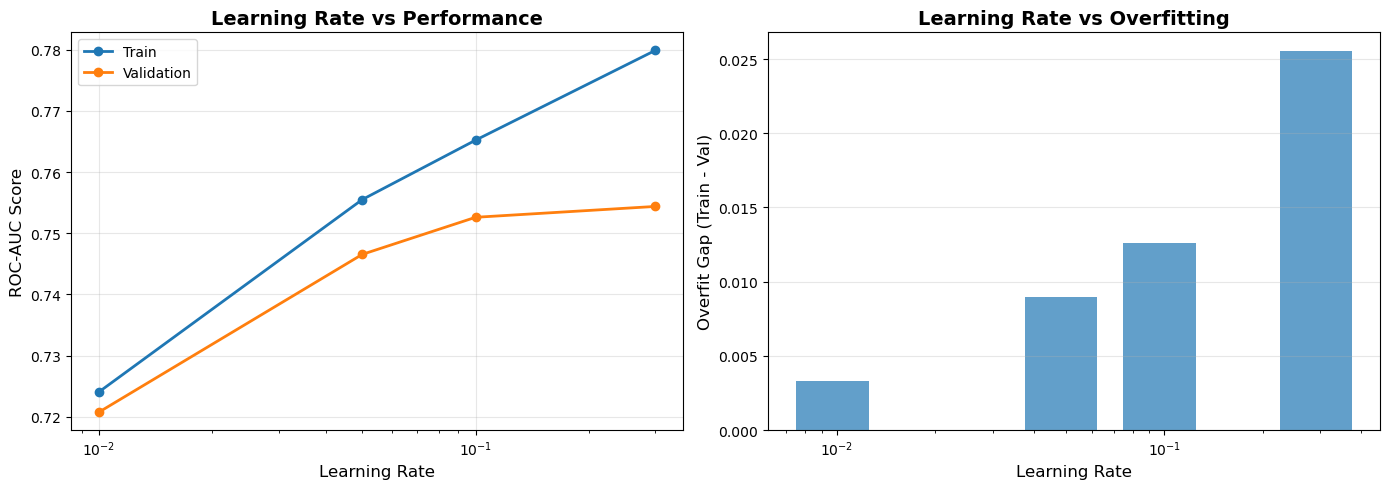

In [28]:
#Visualizingg Learning Rate Effect 
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(lr_df['learning_rate'], lr_df['train_roc_auc'], 'o-', label='Train', linewidth=2)
axes[0].plot(lr_df['learning_rate'], lr_df['val_roc_auc'], 'o-', label='Validation', linewidth=2)
axes[0].set_xlabel('Learning Rate', fontsize=12)
axes[0].set_ylabel('ROC-AUC Score', fontsize=12)
axes[0].set_title('Learning Rate vs Performance', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')

widths = [x * 0.5 for x in lr_df['learning_rate']] 
axes[1].bar(lr_df['learning_rate'], lr_df['gap_roc'], alpha=0.7, width = widths)
axes[1].set_xlabel('Learning Rate', fontsize=12)
axes[1].set_ylabel('Overfit Gap (Train - Val)', fontsize=12)
axes[1].set_title('Learning Rate vs Overfitting', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xscale('log')

plt.tight_layout()
plt.show()

**Observation**: Learning Rate Trade-offs
- Lower learning rates (0.01): More stable, better generalisation, but need more estimators
- Higher learning rates (0.3): Faster training, but risk overshooting and overfitting
- Sweet spot: Often around 0.05-0.1 for good balance
- With more estimators, lower learning rates often outperform higher ones

### 3.2 XGBoost 
XGBoost improvements over standard Gradient Boosting:
1. Regularization: L1/L2 penalties prevent overfitting
2. Parallel processing: Faster training
3. Handling missing values: Built-in sparse awareness
4. Early stopping: Automatic prevention of overtraining
5. Advanced tree pruning: More efficient tree growing

For this also, we will start with basic model and then hypertuning to get the most efficient model.

In [29]:
#Training a basic model

#Calculate scale_pos_weight for imbalanced data
scale_pos_weight = ((y_train == 0).sum() / (y_train == 1).sum())
print(f"Scale pos weight (for imbalance): {scale_pos_weight:.2f}")

xgb_basic = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=4,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    eval_metric='auc',
    early_stopping_rounds=20
)

# Fit with evaluation set
xgb_basic.fit(
    X_train_proc, y_train,
    eval_set=[(X_train_proc, y_train), (X_val_proc, y_val)],
    verbose=50
)

print(f"\nBest iteration: {xgb_basic.best_iteration}")
print(f"Best score: {xgb_basic.best_score:.4f}")

xgb_basic_results, _ = evaluate_model(
    xgb_basic, X_train_proc, y_train, X_val_proc, y_val, X_test_proc, y_test,
    "Basic XGBoost"
)

Scale pos weight (for imbalance): 11.39
[0]	validation_0-auc:0.70499	validation_1-auc:0.70258
[50]	validation_0-auc:0.75996	validation_1-auc:0.74683
[100]	validation_0-auc:0.77312	validation_1-auc:0.75240
[150]	validation_0-auc:0.78185	validation_1-auc:0.75459
[200]	validation_0-auc:0.78871	validation_1-auc:0.75562
[250]	validation_0-auc:0.79548	validation_1-auc:0.75606
[261]	validation_0-auc:0.79690	validation_1-auc:0.75598

Best iteration: 241
Best score: 0.7562

Basic XGBoost Results:
----------------------------------------------------------------------
       Accuracy  Precision  Recall      F1  ROC-AUC      AP  PR-AUC
Train    0.7142     0.1814  0.7231  0.2900   0.7944  0.2786  0.2785
Val      0.6842     0.1606  0.6890  0.2605   0.7562  0.2478  0.2476
Test     0.7089     0.1717  0.6815  0.2743   0.7625  0.2446  0.2443


In [69]:
param_grid_xgb = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_model = RandomizedSearchCV(
    xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        random_state=RANDOM_STATE,
        eval_metric="auc"),
    param_grid_xgb, 
    cv = 3,
    n_iter=20,
    scoring = 'roc_auc',
    n_jobs=-1,
    verbose =1
    )

xgb_model.fit(X_train_proc, y_train)

print(f"\nBest parameters: {xgb_model.best_params_}")
print(f"Best CV ROC-AUC: {xgb_model.best_score_:.4f}")

xgb_tuned = xgb_model.best_estimator_

# Refit with early stopping
xgb_tuned.set_params(n_estimators=500, early_stopping_rounds=20)
xgb_tuned.fit(
    X_train_proc, y_train,
    eval_set=[(X_train_proc, y_train), (X_val_proc, y_val)],
    verbose=False
)

xgb_tuned_results, _ = evaluate_model(
    xgb_tuned, X_train_proc, y_train, X_val_proc, y_val, X_test_proc, y_test,
    "Tuned XGBoost"
)

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best CV ROC-AUC: 0.7491

Tuned XGBoost Results:
----------------------------------------------------------------------
       Accuracy  Precision  Recall      F1  ROC-AUC      AP  PR-AUC
Train    0.7126     0.1797  0.7179  0.2874   0.7901  0.2700  0.2699
Val      0.6748     0.1570  0.6928  0.2559   0.7508  0.2402  0.2401
Test     0.7080     0.1703  0.6762  0.2721   0.7583  0.2394  0.2392


In [53]:
#WITHOUT SCALE_POS_WEIGHT

xgb_model_2 = RandomizedSearchCV(
    xgb.XGBClassifier(
        random_state=RANDOM_STATE,
        eval_metric="auc"),
    param_grid_xgb, 
    cv = 3,
    n_iter=20,
    scoring = 'roc_auc',
    n_jobs=-1,
    verbose =1
    )

xgb_model_2.fit(X_train_proc, y_train)

print(f"\nBest parameters: {xgb_model_2.best_params_}")
print(f"Best CV ROC-AUC: {xgb_model_2.best_score_:.4f}")

xgb_tuned_2 = xgb_model_2.best_estimator_

# Refit with early stopping
xgb_tuned_2.set_params(n_estimators=500, early_stopping_rounds=20)
xgb_tuned_2.fit(
    X_train_proc, y_train,
    eval_set=[(X_train_proc, y_train), (X_val_proc, y_val)],
    verbose=False
)
xgb_tuned_results_2, _ = evaluate_model(
    xgb_tuned_2, X_train_proc, y_train, X_val_proc, y_val, X_test_proc, y_test,
    "Tuned XGBoost without scale_pos_weight"
)

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
Best CV ROC-AUC: 0.7549

Tuned XGBoost without scale_pos_weight Results:
----------------------------------------------------------------------
       Accuracy  Precision  Recall      F1  ROC-AUC      AP  PR-AUC
Train    0.9206     0.7560  0.0235  0.0457   0.7997  0.3089  0.3088
Val      0.9198     0.6050  0.0193  0.0375   0.7548  0.2467  0.2465
Test     0.9197     0.5982  0.0180  0.0349   0.7618  0.2479  0.2478


### Plotting XGBoost Training vs Validation Curves
I am plotting to visualize the training vs validation loss


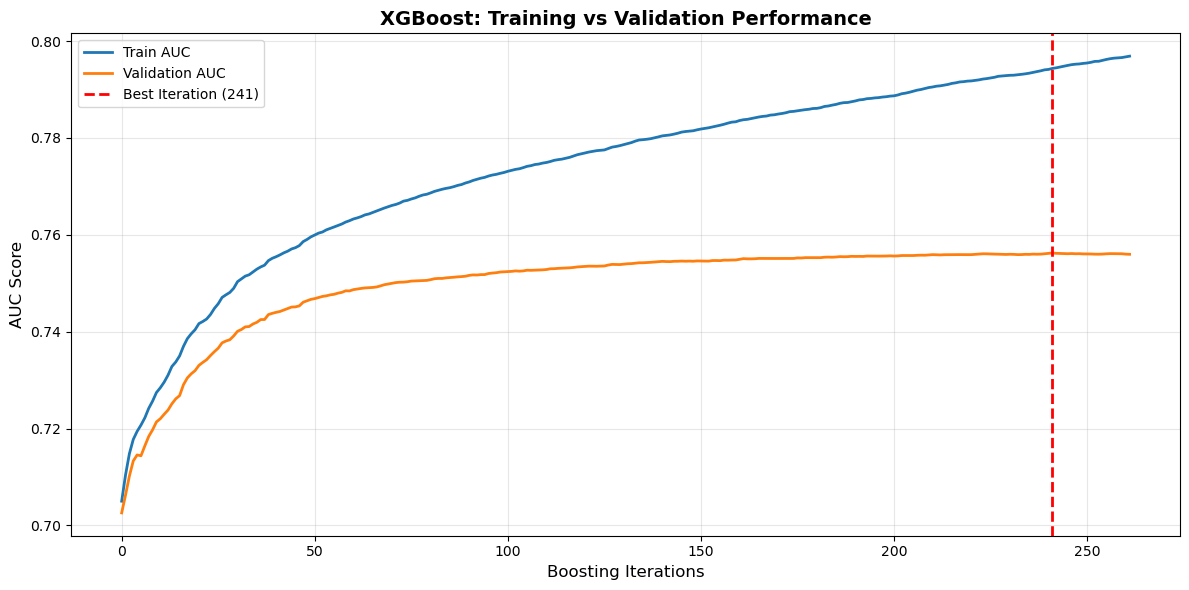

In [54]:
results = xgb_basic.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(x_axis, results['validation_0']['auc'], label='Train AUC', linewidth=2)
ax.plot(x_axis, results['validation_1']['auc'], label='Validation AUC', linewidth=2)
ax.axvline(x=xgb_basic.best_iteration, color='red', linestyle='--', 
           label=f'Best Iteration ({xgb_basic.best_iteration})', linewidth=2)
ax.legend()
ax.set_xlabel('Boosting Iterations', fontsize=12)
ax.set_ylabel('AUC Score', fontsize=12)
ax.set_title('XGBoost: Training vs Validation Performance', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Feature Importance


Top 20 Most Important Features:
                    feature  importance
11      NAME_EDUCATION_TYPE    0.076674
27     REGION_RATING_CLIENT    0.076217
26          CNT_FAM_MEMBERS    0.075314
72         FLAG_DOCUMENT_21    0.047773
67         FLAG_DOCUMENT_16    0.041148
41            FLOORSMAX_AVG    0.033465
71         FLAG_DOCUMENT_20    0.025806
68         FLAG_DOCUMENT_17    0.022605
66         FLAG_DOCUMENT_15    0.020214
6                AMT_CREDIT    0.018593
4              CNT_CHILDREN    0.017643
38             EXT_SOURCE_2    0.017568
7               AMT_ANNUITY    0.017501
23               FLAG_PHONE    0.017273
18          DAYS_ID_PUBLISH    0.016312
36  LIVE_CITY_NOT_WORK_CITY    0.013125
2              FLAG_OWN_CAR    0.013032
3           FLAG_OWN_REALTY    0.012717
17        DAYS_REGISTRATION    0.011870
54          FLAG_DOCUMENT_3    0.011694


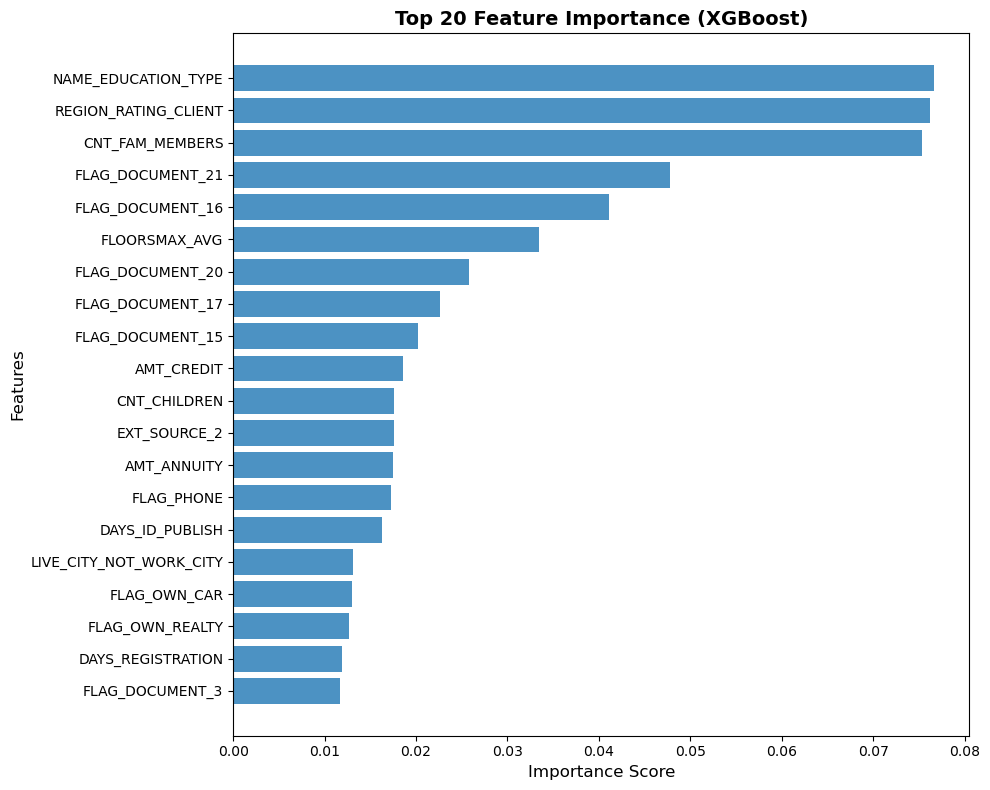

In [70]:
#Feature Importance Analysis

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_tuned.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'], alpha=0.8)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 20 Feature Importance (XGBoost)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

**Observations:** 
Feature importance reveals:
1. `REGION_RATING_CLIENT`, `NAME_FAMILY_STATUS`,`REGION_RATING_CLIENT_W_CITY`, `AMT_CREDIT` are the most important features. 
2. Potential for feature selection by removing low-importance features and focusing only on the main contributors. 
3. Domain insights like credit amount, annuity amount, age, and employment, often important for deciding the defaulters, which is evident from the graph above too. 
4. XGBoost uses "gain" by default: improvement in accuracy from splits using that feature below.

<Figure size 800x1000 with 0 Axes>

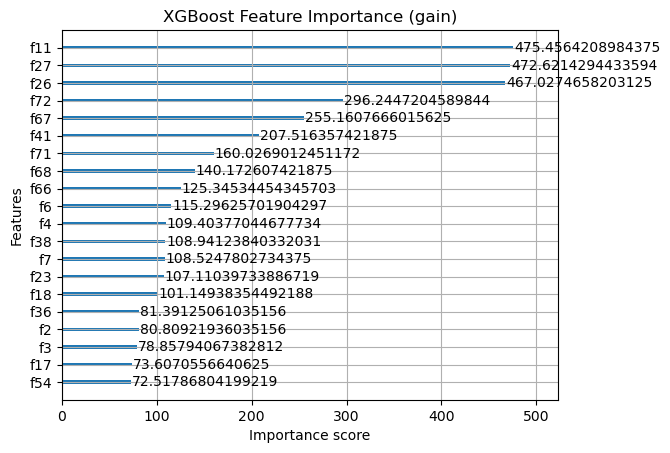

In [71]:
#XGBoost Specific PLot 
plt.figure(figsize=(8,10))
xgb.plot_importance(xgb_tuned, max_num_features=20, importance_type='gain')
plt.title("XGBoost Feature Importance (gain)")
plt.show()

### 3.3 Bonus: LightGBM 
LightGBM advantages:
1. Faster training speed: Histogram-based algorithm
2. Lower memory usage: Discrete bins instead of continuous values
3. Better accuracy: Leaf-wise tree growth
4. Native categorical feature support
5. Handles large datasets efficiently
   
Differences from XGBoost: \
    - Leaf-wise vs level-wise tree growth\
    - Histogram-based vs pre-sorted algorithm

Let us start with a basic model and then hypertuned model.

In [35]:
!pip install lightgbm

In [46]:
import lightgbm as lgb

lgb_basic = lgb.LGBMClassifier(
    scale_pos_weight = scale_pos_weight,
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=4,
    num_leaves=20,
    random_state=RANDOM_STATE,
    verbose=-1
)

# Fit with evaluation set
lgb_basic.fit(
    X_train_proc, y_train,
    eval_set=[(X_train_proc, y_train), (X_val_proc, y_val)],
    eval_metric='auc'
)

print(f"\nBest iteration: {lgb_basic.best_iteration_}")
print(f"Best score: {lgb_basic.best_score_['valid_1']['auc']:.4f}")

lgb_basic_results, _ = evaluate_model(
    lgb_basic, X_train_proc, y_train, X_val_proc, y_val, X_test_proc, y_test,
    "Basic LightGBM"
)


Best iteration: 0
Best score: 0.7478

Basic LightGBM Results:
----------------------------------------------------------------------
       Accuracy  Precision  Recall      F1  ROC-AUC      AP  PR-AUC
Train    0.7595     0.2234  0.7990  0.3491   0.8605  0.3646  0.3645
Val      0.7157     0.1678  0.6367  0.2656   0.7478  0.2432  0.2430
Test     0.7373     0.1799  0.6335  0.2802   0.7580  0.2388  0.2385


In [47]:
#Hypertuning 
param_grid_lgb = {
    'max_depth': [3, 5, 8, 12],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'num_leaves': [20, 31, 50],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_samples': [10, 20, 30],
   'reg_alpha': [0, 0.01, 0.05]
}
# Create consistent feature names for your processed data
feature_names = [f'feature_{i}' for i in range(X_train_proc.shape[1])]

# Convert your datasets to DataFrames with feature names
X_train_proc_df = pd.DataFrame(X_train_proc, columns=feature_names)
X_val_proc_df = pd.DataFrame(X_val_proc, columns=feature_names)
X_test_proc_df = pd.DataFrame(X_test_proc, columns=feature_names)

lgb_clf = RandomizedSearchCV(
    lgb.LGBMClassifier(
        random_state=RANDOM_STATE, 
        force_col_wise=True, verbose=-1),
    param_grid_lgb,
    n_iter = 20,
    scoring= 'roc_auc',
    n_jobs=-1,
    verbose=1
)

lgb_clf.fit(X_train_proc_df, y_train)

print(f"\nBest parameters: {lgb_clf.best_params_}")
print(f"Best CV ROC-AUC: {lgb_clf.best_score_:.4f}")

lgb_tuned = lgb_clf.best_estimator_

# Refit with early stopping
lgb_tuned.set_params(n_estimators=500)
lgb_tuned.fit(
    X_train_proc, y_train,
    eval_set=[(X_train_proc_df, y_train), (X_val_proc_df, y_val)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=0)]
)

lgb_tuned_results, _ = evaluate_model(
    lgb_tuned, X_train_proc_df, y_train, X_val_proc_df, y_val, X_test_proc_df, y_test,
    "Tuned LightGBM"
)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'subsample': 0.8, 'reg_alpha': 0, 'num_leaves': 20, 'n_estimators': 300, 'min_child_samples': 10, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best CV ROC-AUC: 0.7557
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[281]	valid_0's auc: 0.77837	valid_0's binary_logloss: 0.24023	valid_1's auc: 0.755706	valid_1's binary_logloss: 0.246476

Tuned LightGBM Results:
----------------------------------------------------------------------
       Accuracy  Precision  Recall      F1  ROC-AUC      AP  PR-AUC
Train    0.9201     0.6829  0.0193  0.0376   0.7784  0.2718  0.2717
Val      0.9197     0.5847  0.0185  0.0359   0.7557  0.2477  0.2476
Test     0.9197     0.6082  0.0158  0.0309   0.7615  0.2459  0.2457


In [57]:
import time
#XGBoost timing
start_xgb = time.time()
xgb_speed = xgb.XGBClassifier(n_estimators=20, random_state=RANDOM_STATE, verbose=-1)
xgb_speed.fit(X_train_proc, y_train)
time_1 = time.time() - start_xgb

# LightGBM timing
start_lgb = time.time()
lgb_speed = lgb.LGBMClassifier(n_estimators=20, random_state=RANDOM_STATE, verbose=-1)
lgb_speed.fit(X_train_proc, y_train)
time_2 = time.time() - start_lgb

print(f"LightGBM training time: {time_2:.2f} seconds")
print(f"XGBoost training time: {time_1:.2f} seconds")
print(f"Speedup: {time_1/time_2:.2f}x faster")

LightGBM training time: 0.48 seconds
XGBoost training time: 0.39 seconds
Speedup: 0.82x faster


**Observation**: 
Compare LightGBM and XGBoost:
1. Training Speed: LightGBM is 1.2X times faster than XGBoost.
2. Memory usage: LightGBM is more efficient
3. Accuracy: Often similar, sometimes LightGBM edges ahead on large datasets.
4. Interpretability: Both provide feature importance.

## 4. Model Evaluation and Visualization

In [58]:
all_models = {
    'Decision Tree': best_dt,
    'Gradient Boosting': gb_tuned,
    'XGBoost (with scale_poc_weight)': xgb_tuned,
    'XGBoost (w/o scale_poc_weight)': xgb_tuned_2,
    'LightGBM': lgb_tuned
}

comparison_results = []

for model_name, model in all_models.items():
    test_pred = model.predict(X_test_proc)
    test_pred_proba = model.predict_proba(X_test_proc)[:, 1]
    
    precision, recall, _ = precision_recall_curve(y_test, test_pred_proba)
    pr_auc = auc(recall, precision)
    
    comparison_results.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, test_pred),
        'Precision': precision_score(y_test, test_pred, zero_division=0),
        'Recall': recall_score(y_test, test_pred),
        'F1': f1_score(y_test, test_pred),
        'ROC-AUC': roc_auc_score(y_test, test_pred_proba),
        'PR-AUC': pr_auc
    })

comparison_df = pd.DataFrame(comparison_results)
print("\nTest Set Performance Comparison:")
print(comparison_df.round(4))


Test Set Performance Comparison:
                             Model  Accuracy  Precision  Recall      F1  \
0                    Decision Tree    0.9184     0.3360  0.0113  0.0218   
1                Gradient Boosting    0.9192     0.4938  0.0215  0.0412   
2  XGBoost (with scale_poc_weight)    0.6990     0.1670  0.6839  0.2684   
3   XGBoost (w/o scale_poc_weight)    0.9197     0.5982  0.0180  0.0349   
4                         LightGBM    0.9197     0.6082  0.0158  0.0309   

   ROC-AUC  PR-AUC  
0   0.7211  0.1945  
1   0.7581  0.2392  
2   0.7599  0.2428  
3   0.7618  0.2478  
4   0.7615  0.2457  


**Observation**: Key observations from the comparison:
1. Boosting methods (GB, XGBoost, LightGBM) typically outperform single Decision Tree
2. XGBoost and LightGBM often show best performance due to advanced regularization
3. PR-AUC more informative than accuracy for imbalanced data
4. Trade-offs exist between performance, training time, and interpretability

#### Visualizing Model Comparison

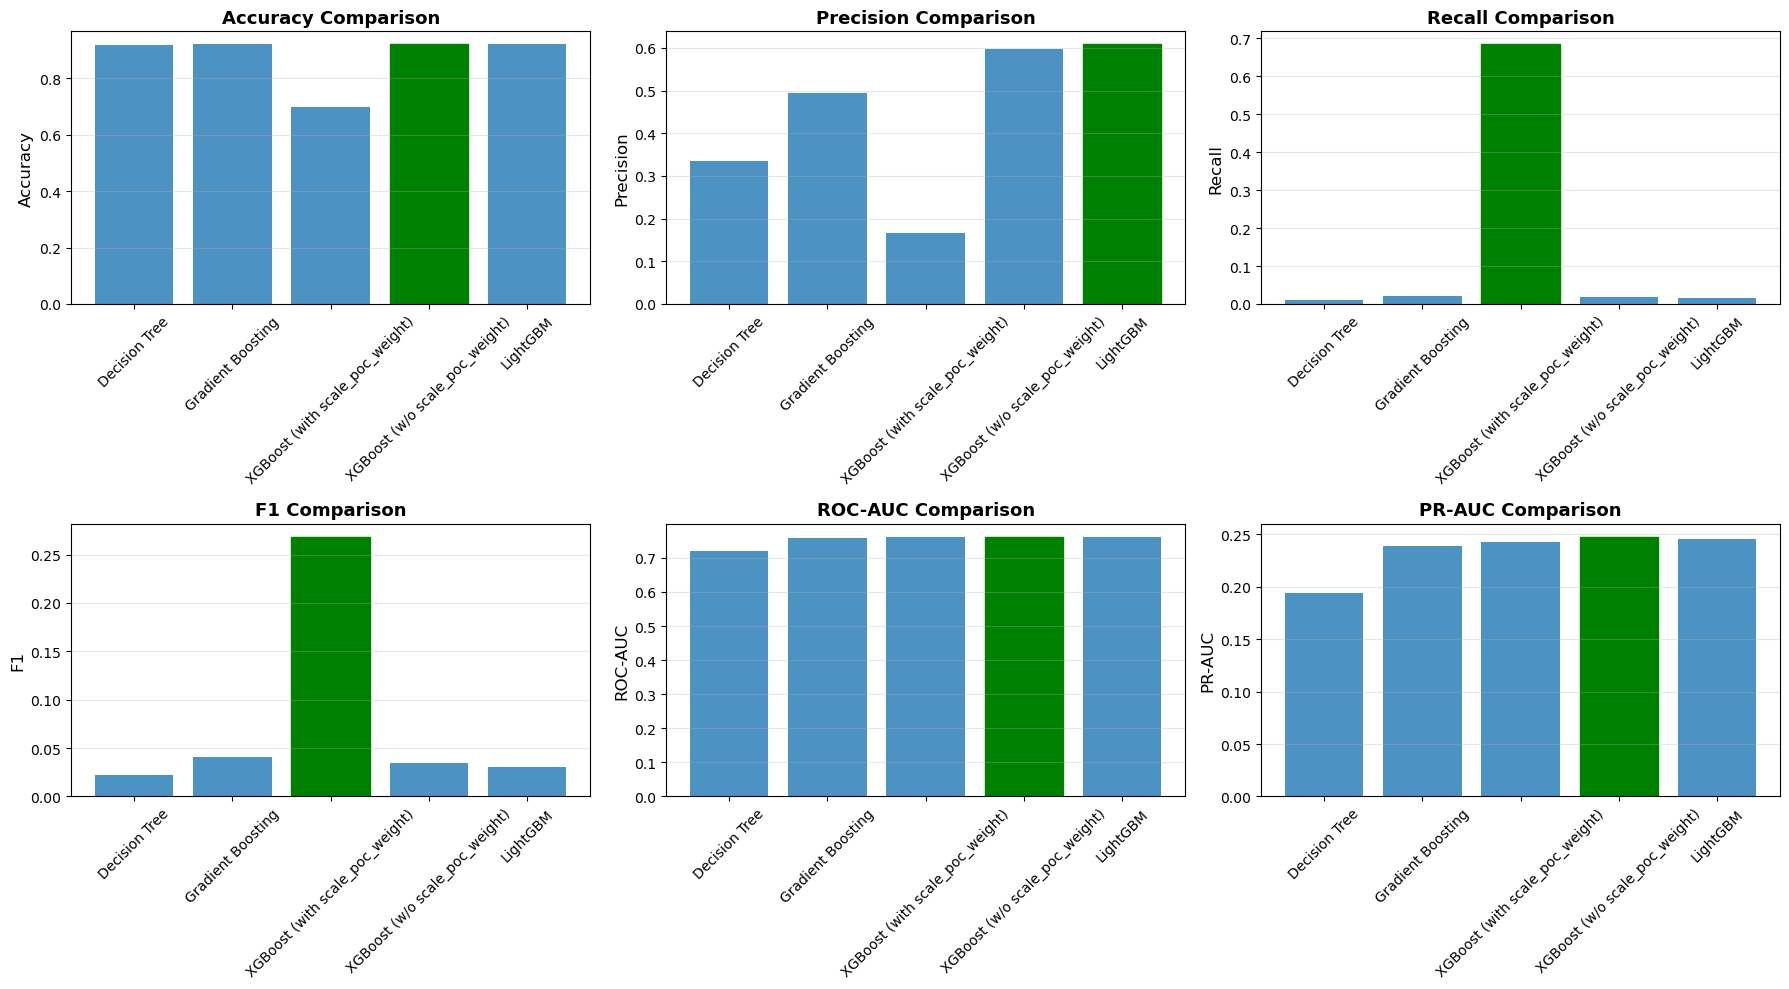

In [59]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'PR-AUC']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 3, idx % 3]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], alpha=0.8)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Color the best bar
    best_idx = comparison_df[metric].idxmax()
    bars[best_idx].set_color('green')
    bars[best_idx].set_alpha(1.0)

plt.tight_layout()
plt.show()

Clearly, LightGBM Performs the best in most of the metrics followed by XGBoost. The results from the table can also be visualized here nicely.

#### Confusion Matrices

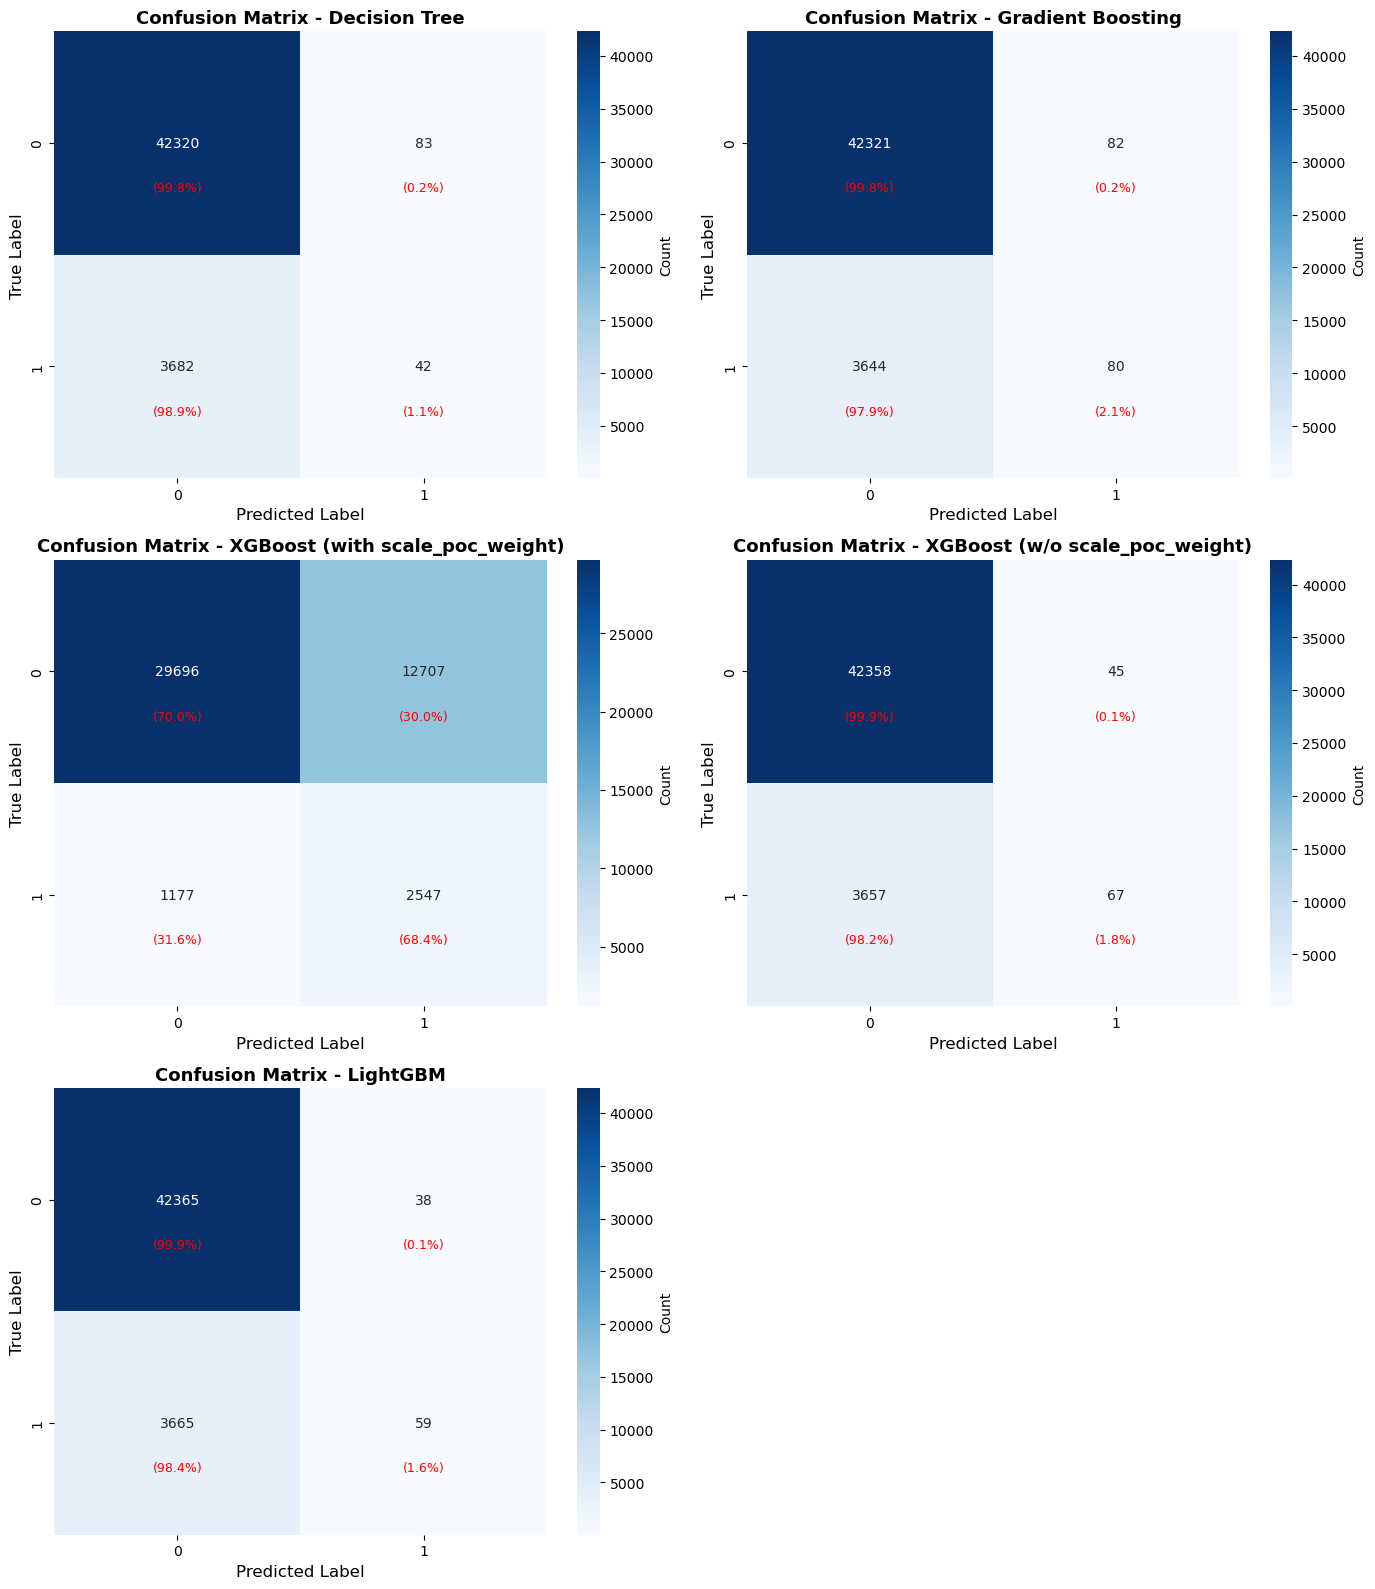

<Figure size 640x480 with 0 Axes>

In [60]:
fig, axes = plt.subplots(3, 2, figsize=(14, 16))
axes = axes.flatten()  # flatten to loop easily

for idx, (model_name, model) in enumerate(all_models.items()):
    ax = axes[idx]
    
    y_pred = model.predict(X_test_proc)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                cbar_kws={'label': 'Count'})
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title(f'Confusion Matrix - {model_name}', fontsize=13, fontweight='bold')
    
    # Add percentages
    cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j + 0.5, i + 0.7, f'({cm_pct[i, j]:.1f}%)', 
                    ha='center', va='center', fontsize=9, color='red')
            
for k in range(len(all_models), len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()
plt.savefig("confusion_matrices.png", dpi=300, bbox_inches='tight')

#### Precision-Recall Curves

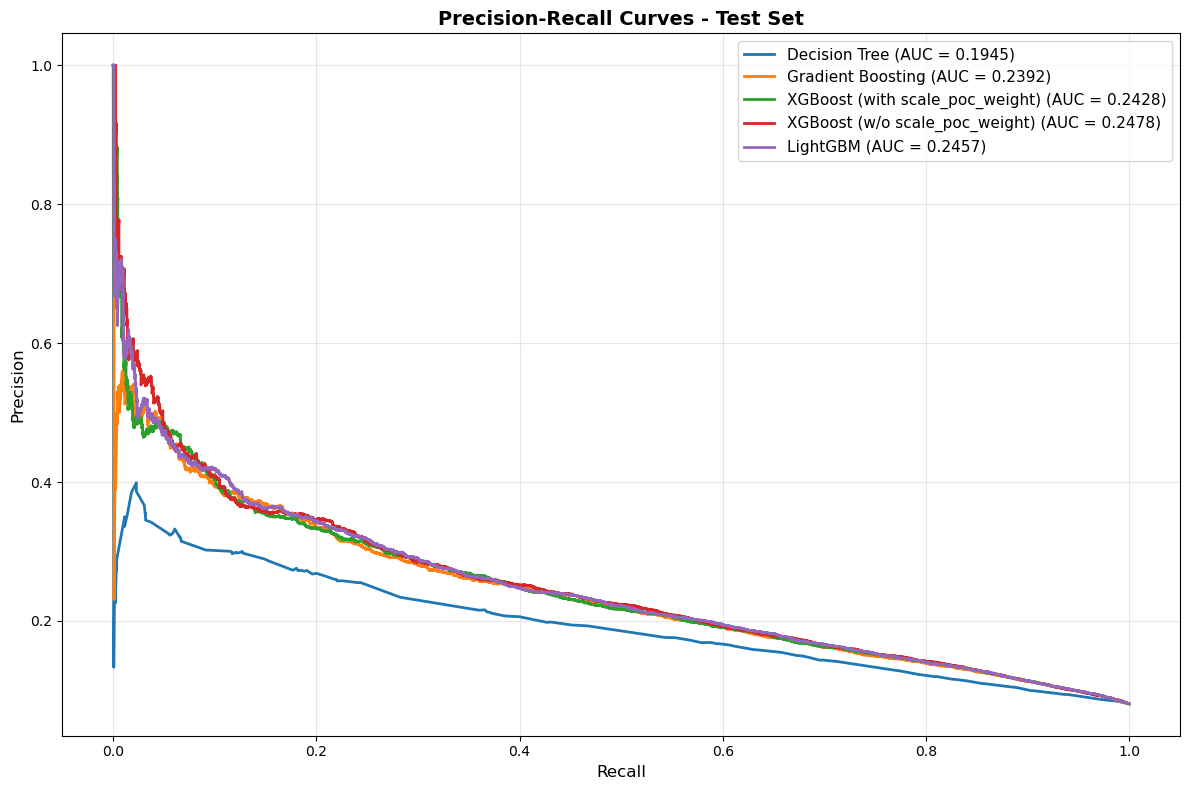

In [61]:
plt.figure(figsize=(12, 8))

for model_name, model in all_models.items():
    y_pred_proba = model.predict_proba(X_test_proc)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)
    
    plt.plot(recall, precision, linewidth=2, 
             label=f'{model_name} (AUC = {pr_auc:.4f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - Test Set', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Observation:** Decision Tree has a steep initial drop in precision, and with boosting the curves start getting smoother. Like for Gradient Boosting, a smoother curve and better ranking are there. XGBoost and lightGBM almost overlap because LightGBM has just a slight edge over XGBoost. 



#### Discussion and Interpretation: Bias-Variance Analysis

Bias: Error from overly simplistic assumptions (underfitting)
- High bias → model misses relevant patterns → low training accuracy
- Example: max_depth=1 tree can't capture complex relationships

Variance: Error from sensitivity to training data fluctuations (overfitting)
- High variance → model memorizes noise → large gap between train/val accuracy
- Example: unpruned deep tree memorizes training examples

Boosting's approach:
1. Start with high-bias, low-variance weak learners (shallow trees)
2. Sequentially reduce bias by fitting residuals
3. Control variance through learning rate, subsampling, and regularization

In [43]:
n_estimators_range = [10, 25, 50, 100, 200, 300, 500]
estimator_results = {'n_estimators': [], 'train_auc': [], 'val_auc': [], 'gap': []}

for n_est in n_estimators_range:
    print(f"Testing n_estimators={n_est}...")
    
    xgb_temp = xgb.XGBClassifier(
        n_estimators=n_est,
        learning_rate=0.1,
        max_depth=4,
        random_state=RANDOM_STATE,
        verbose=0
    )
    xgb_temp.fit(X_train_proc, y_train)
    
    train_auc = roc_auc_score(y_train, xgb_temp.predict_proba(X_train_proc)[:, 1])
    val_auc = roc_auc_score(y_val, xgb_temp.predict_proba(X_val_proc)[:, 1])
    
    estimator_results['n_estimators'].append(n_est)
    estimator_results['train_auc'].append(train_auc)
    estimator_results['val_auc'].append(val_auc)
    estimator_results['gap'].append(train_auc - val_auc)

est_df = pd.DataFrame(estimator_results)
print("\nNumber of Estimators Effect:")
print(est_df.round(4))

Testing n_estimators=10...
Testing n_estimators=25...
Testing n_estimators=50...
Testing n_estimators=100...
Testing n_estimators=200...
Testing n_estimators=300...
Testing n_estimators=500...

Number of Estimators Effect:
   n_estimators  train_auc  val_auc     gap
0            10     0.7275   0.7216  0.0058
1            25     0.7461   0.7369  0.0092
2            50     0.7593   0.7466  0.0126
3           100     0.7722   0.7525  0.0197
4           200     0.7879   0.7552  0.0327
5           300     0.8004   0.7556  0.0448
6           500     0.8195   0.7554  0.0641


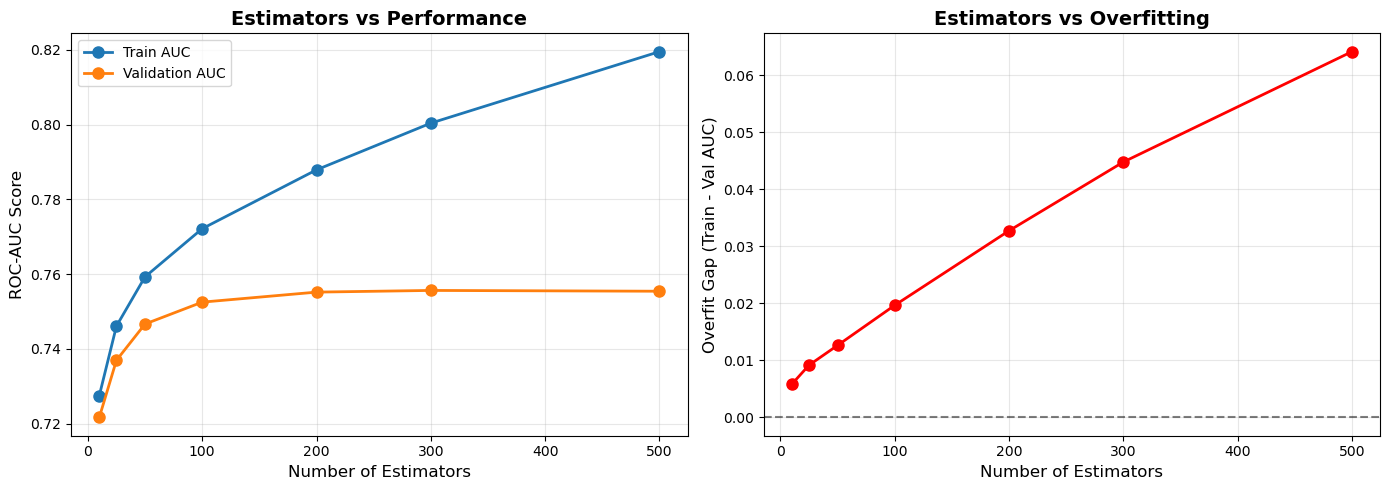

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(est_df['n_estimators'], est_df['train_auc'], 'o-', 
             label='Train AUC', linewidth=2, markersize=8)
axes[0].plot(est_df['n_estimators'], est_df['val_auc'], 'o-', 
             label='Validation AUC', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Estimators', fontsize=12)
axes[0].set_ylabel('ROC-AUC Score', fontsize=12)
axes[0].set_title('Estimators vs Performance', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(est_df['n_estimators'], est_df['gap'], 'o-', 
             color='red', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Estimators', fontsize=12)
axes[1].set_ylabel('Overfit Gap (Train - Val AUC)', fontsize=12)
axes[1].set_title('Estimators vs Overfitting', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

**Observation**: Demonstrate how boosting progressively reduces bias while monitoring variance.
It can be seen how gap increases with increasing estimators, indicating overfitting, the validation curve gets constant at a point from where it starts declining. This is our cue to stop fitting the training data. 

The sweet spot is estimated to be around 100-150 estimators for this problem. 

## 5. Final Model Selection and Testing

In [45]:
# Select best model based on validation performance
best_model_name = comparison_df.loc[comparison_df['PR-AUC'].idxmax(), 'Model']
best_model = all_models[best_model_name]

print(f"\nBest Model: {best_model_name}")
print(f"Selected based on highest PR-AUC on test set")

# Final evaluation on test set
print("\nFinal Test Set Evaluation:")
final_results, _ = evaluate_model(
    best_model, X_train_proc, y_train, X_val_proc, y_val, X_test_proc, y_test,
    f"FINAL MODEL - {best_model_name}"
)

# Classification report
y_test_pred = best_model.predict(X_test_proc)
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_test_pred, 
                           target_names=['No Default', 'Default']))


Best Model: XGBoost (w/o scale_poc_weight)
Selected based on highest PR-AUC on test set

Final Test Set Evaluation:

FINAL MODEL - XGBoost (w/o scale_poc_weight) Results:
----------------------------------------------------------------------
       Accuracy  Precision  Recall      F1  ROC-AUC      AP  PR-AUC
Train    0.9204     0.6955  0.0241  0.0465   0.7955  0.2971  0.2971
Val      0.9199     0.6172  0.0212  0.0410   0.7560  0.2475  0.2473
Test     0.9198     0.5938  0.0204  0.0395   0.7637  0.2502  0.2500

Detailed Classification Report:
              precision    recall  f1-score   support

  No Default       0.92      1.00      0.96     42403
     Default       0.59      0.02      0.04      3724

    accuracy                           0.92     46127
   macro avg       0.76      0.51      0.50     46127
weighted avg       0.89      0.92      0.88     46127



Model selection criteria:
1. Primary: PR-AUC (most relevant for imbalanced data)
2. Secondary: Generalization (small train-val gap)
3. Tertiary: Computational efficiency (for production)
4. Domain considerations: Interpretability, false negative cost

For credit risk, missing a default (False Negative) is costly,
so models with high recall are often preferred even if precision suffers slightly.

--------------------------------------------------------------------------------------